In [3]:
# ============================================================================
# CETM26 Assignment 2: Wildlife Classification System
# Student: Chiwama Michael Mwela
# Date: October 2025
# 
# RESEARCH QUESTION:
# How effective is data augmentation combined with transfer learning for 
# multi-class wildlife image classification on limited datasets?
#
# OBJECTIVES:
# 1. Compare custom CNN vs Transfer Learning approaches
# 2. Evaluate impact of data augmentation techniques
# 3. Analyze model performance across wildlife classes
# 4. Recommend optimal approach for wildlife conservation applications
# ============================================================================

# Suppress warnings for cleaner output
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

# Core imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Suppress TensorFlow logging
tf.get_logger().setLevel('ERROR')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("="*80)
print("WILDLIFE CLASSIFICATION SYSTEM - Assignment 2")
print("="*80)
print(f"TensorFlow Version: {tf.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print("="*80)

WILDLIFE CLASSIFICATION SYSTEM - Assignment 2
TensorFlow Version: 2.10.0
NumPy Version: 1.26.4
GPU Available: True


In [2]:
# Suppress TensorFlow warnings (add at the very top)
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TF info/warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Only show errors

print("✓ Warnings suppressed for cleaner output")

✓ Warnings suppressed for cleaner output


In [4]:
import gc

# Disable GPU completely to avoid crashes
tf.config.set_visible_devices([], 'GPU')
print("GPU disabled - using CPU only for stability")

# Optimize CPU threading
tf.config.threading.set_inter_op_parallelism_threads(2)
tf.config.threading.set_intra_op_parallelism_threads(2)

print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())

GPU disabled - using CPU only for stability
TensorFlow version: 2.10.0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]



SECTION 1: DATA LOADING & EXPLORATION

Original CIFAR-10 Dataset:
  Training samples: 50,000
  Test samples: 10,000
  Image shape: (32, 32, 3)

Filtered Wildlife Dataset:
  Training samples: 15,000
  Test samples: 3,000
  Classes: ['Bird', 'Deer', 'Horse']

Class Distribution:
  Bird: Train=5,000, Test=1,000
  Deer: Train=5,000, Test=1,000
  Horse: Train=5,000, Test=1,000

Final Dataset Splits:
  Training: 12,000 samples
  Validation: 3,000 samples
  Test: 3,000 samples


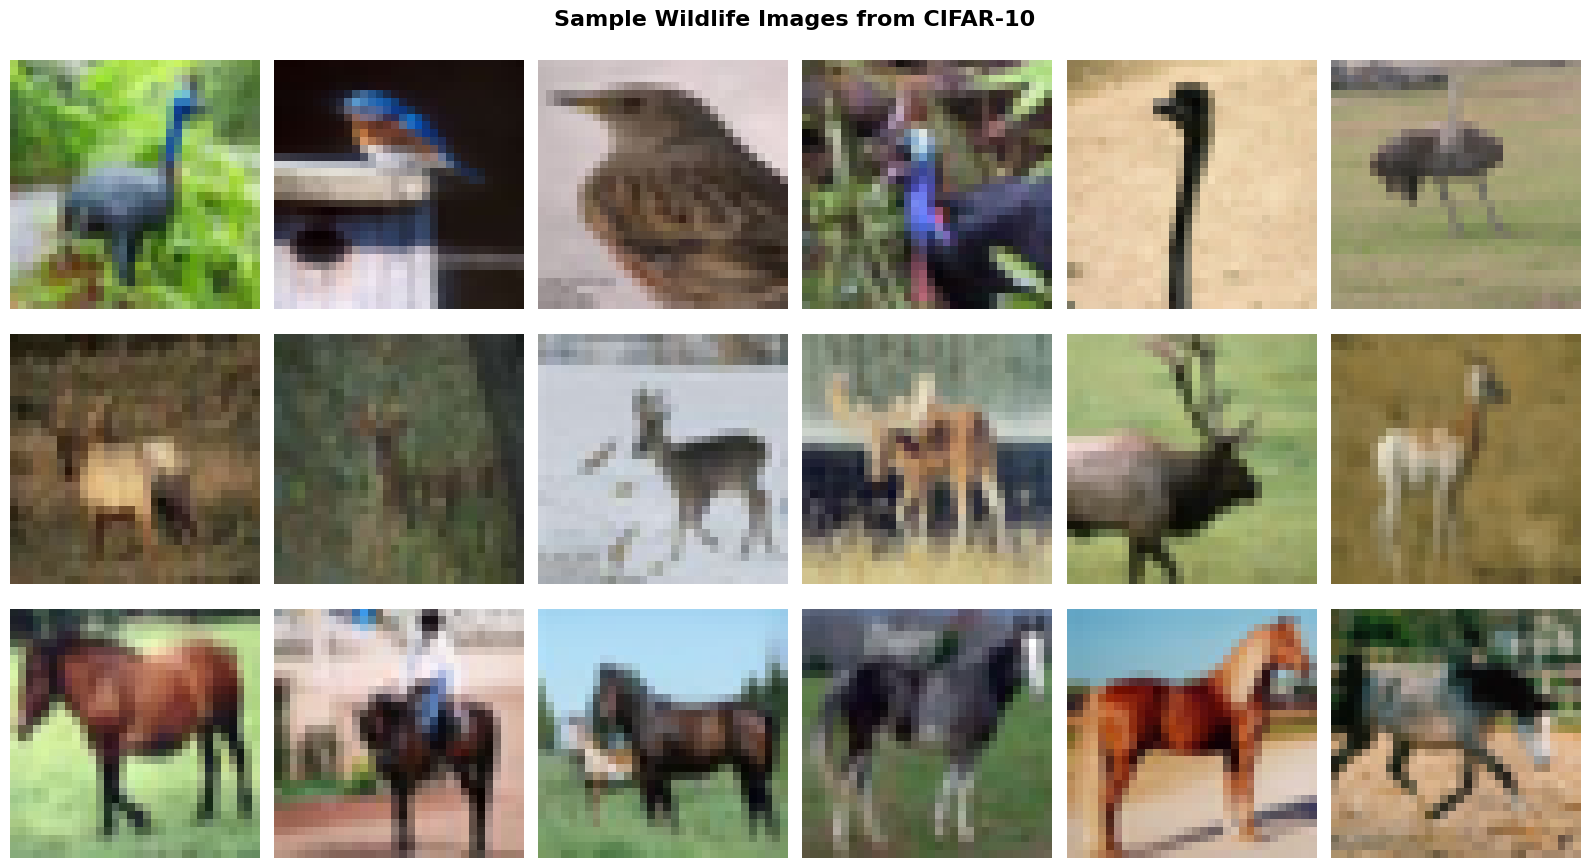


✓ Data preparation completed successfully!


In [5]:
# ============================================================================
# SECTION 1: DATA PREPARATION & EXPLORATION
# ============================================================================
print("\n" + "="*80)
print("SECTION 1: DATA LOADING & EXPLORATION")
print("="*80)

# Load CIFAR-10 dataset
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

print(f"\nOriginal CIFAR-10 Dataset:")
print(f"  Training samples: {len(X_train_full):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Image shape: {X_train_full.shape[1:]}")

# Wildlife classes mapping (CIFAR-10 indices to our classes)
wildlife_map = {2: 0, 4: 1, 7: 2}  # bird=0, deer=1, horse=2
class_names = ['Bird', 'Deer', 'Horse']

def filter_wildlife(X, y):
    """Extract only bird, deer, and horse samples from CIFAR-10"""
    mask = np.isin(y.flatten(), [2, 4, 7])
    X_filtered = X[mask]
    y_filtered = np.array([wildlife_map[label[0]] for label in y[mask]])
    return X_filtered, y_filtered

# Filter datasets
X_train_filtered, y_train_filtered = filter_wildlife(X_train_full, y_train_full)
X_test_filtered, y_test_filtered = filter_wildlife(X_test, y_test)

print(f"\nFiltered Wildlife Dataset:")
print(f"  Training samples: {len(X_train_filtered):,}")
print(f"  Test samples: {len(X_test_filtered):,}")
print(f"  Classes: {class_names}")

# Class distribution analysis
train_dist = pd.Series(y_train_filtered).value_counts().sort_index()
test_dist = pd.Series(y_test_filtered).value_counts().sort_index()

print(f"\nClass Distribution:")
for i, name in enumerate(class_names):
    print(f"  {name}: Train={train_dist[i]:,}, Test={test_dist[i]:,}")

# Normalize pixel values to [0, 1]
X_train = X_train_filtered.astype('float32') / 255.0
X_test = X_test_filtered.astype('float32') / 255.0

# Create validation split (20% of training data)
val_split = 0.2
split_idx = int(len(X_train) * (1 - val_split))
X_train_split = X_train[:split_idx]
y_train_split = y_train_filtered[:split_idx]
X_val = X_train[split_idx:]
y_val = y_train_filtered[split_idx:]

print(f"\nFinal Dataset Splits:")
print(f"  Training: {len(X_train_split):,} samples")
print(f"  Validation: {len(X_val):,} samples")
print(f"  Test: {len(X_test):,} samples")

# Visualize sample images from each class
fig, axes = plt.subplots(3, 6, figsize=(16, 9))
fig.suptitle('Sample Wildlife Images from CIFAR-10', fontsize=16, fontweight='bold')

for i, class_idx in enumerate(range(3)):
    samples = X_train_split[y_train_split == class_idx][:6]
    for j in range(6):
        axes[i, j].imshow(samples[j])
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_ylabel(class_names[i], fontsize=14, fontweight='bold', rotation=0, ha='right')

plt.tight_layout()
plt.show()

print("\n✓ Data preparation completed successfully!")


SECTION 2: DATA AUGMENTATION

Implementing data augmentation techniques:
  - Random horizontal flip
  - Random rotation (±15°)
  - Random zoom (±10%)
  - Random contrast adjustment
  - Random brightness adjustment

Generating augmentation visualization...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [8.552424..9.3877535].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [15.269655..16.189825].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [8.778806..9.621047].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [13.754693..14.640171].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [24.384148..25.224337].


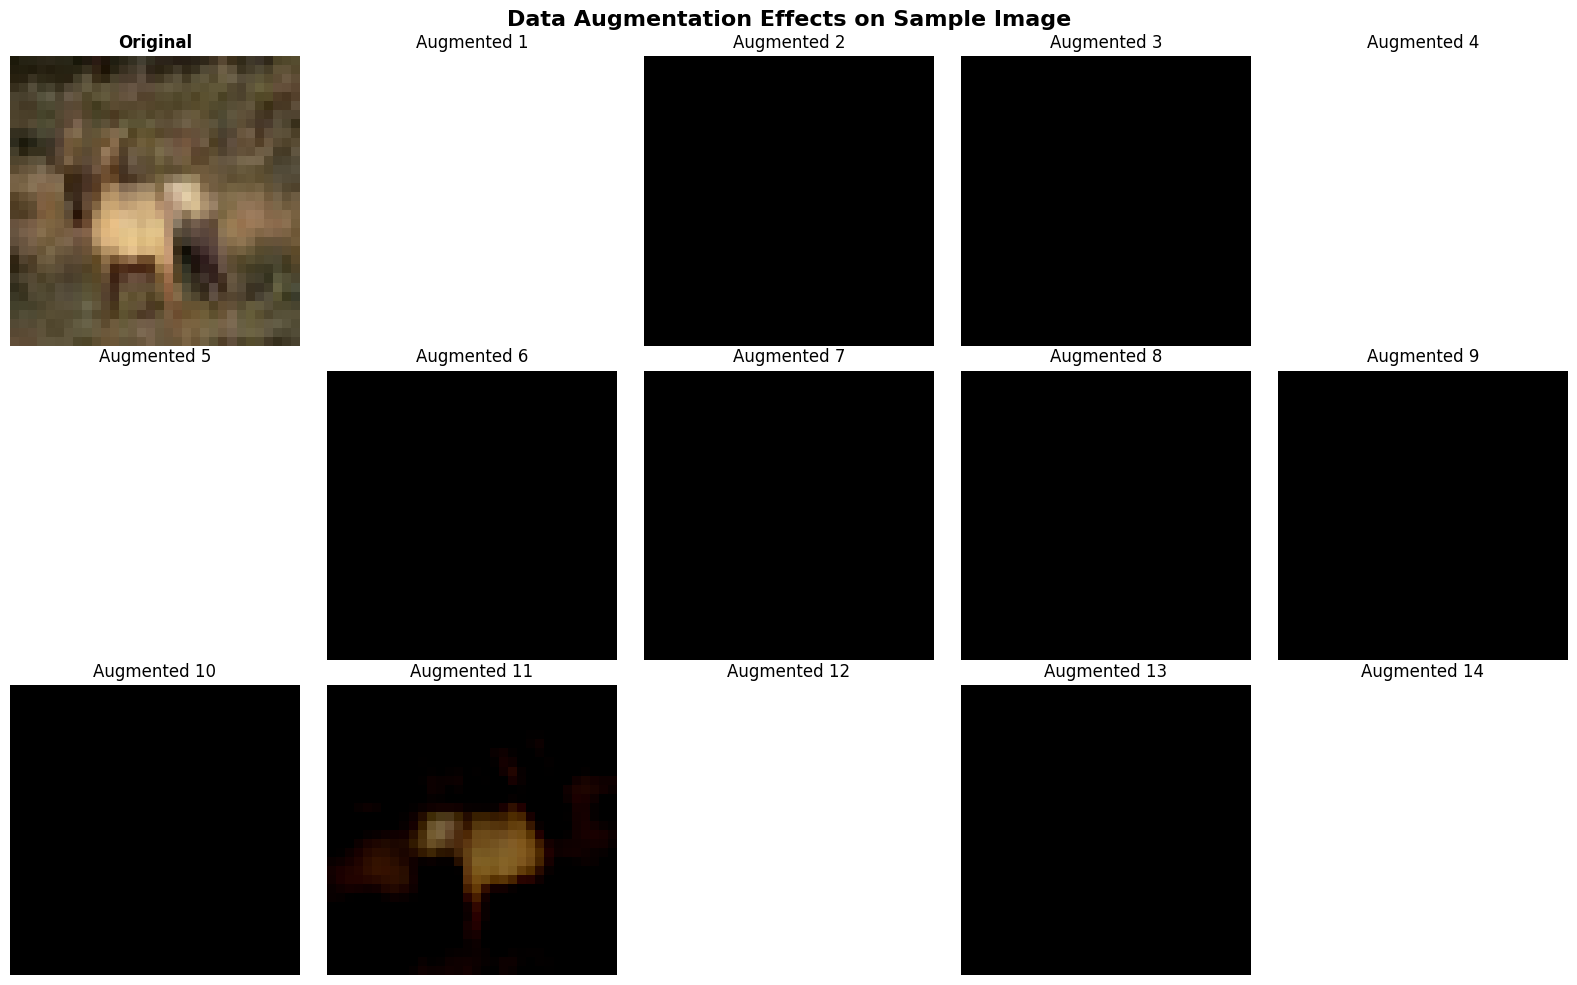

✓ Data augmentation pipeline created successfully!


In [6]:
# ============================================================================
# SECTION 2: DATA AUGMENTATION STRATEGIES
# ============================================================================
print("\n" + "="*80)
print("SECTION 2: DATA AUGMENTATION")
print("="*80)

print("\nImplementing data augmentation techniques:")
print("  - Random horizontal flip")
print("  - Random rotation (±15°)")
print("  - Random zoom (±10%)")
print("  - Random contrast adjustment")
print("  - Random brightness adjustment")

# Create augmentation pipeline using Keras preprocessing layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1)
], name='data_augmentation')

# Visualize augmentation effects
print("\nGenerating augmentation visualization...")
sample_image = X_train_split[0:1]

fig, axes = plt.subplots(3, 5, figsize=(16, 10))
fig.suptitle('Data Augmentation Effects on Sample Image', fontsize=16, fontweight='bold')

# Original image
axes[0, 0].imshow(sample_image[0])
axes[0, 0].set_title('Original', fontweight='bold')
axes[0, 0].axis('off')

# Apply augmentation multiple times
aug_idx = 1
for row in range(3):
    start_col = 1 if row == 0 else 0
    for col in range(start_col, 5):
        augmented = data_augmentation(sample_image, training=True)
        axes[row, col].imshow(augmented[0])
        axes[row, col].set_title(f'Augmented {aug_idx}')
        axes[row, col].axis('off')
        aug_idx += 1

plt.tight_layout()
plt.show()

print("✓ Data augmentation pipeline created successfully!")

In [18]:
# ============================================================================
# SECTION 3: MODEL ARCHITECTURES
# ============================================================================
print("\n" + "="*80)
print("SECTION 3: MODEL ARCHITECTURES")
print("="*80)

# Import keras models with alias to avoid conflicts
from tensorflow.keras import models as keras_models

IMG_SHAPE = (32, 32, 3)
NUM_CLASSES = 3

print("\nDefining 5 model architectures for comparison:")
print("  1. Baseline CNN (no augmentation)")
print("  2. Augmented CNN (with data augmentation)")
print("  3. VGG16 Transfer Learning")
print("  4. ResNet50 Transfer Learning")
print("  5. MobileNetV2 Transfer Learning")

# Model 1: Baseline CNN (No Augmentation)
def create_baseline_cnn():
    """Simple CNN without data augmentation - serves as baseline"""
    model = keras_models.Sequential([
        layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=IMG_SHAPE),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ], name='Baseline_CNN')
    return model

# Model 2: CNN with Data Augmentation
def create_augmented_cnn():
    """CNN with data augmentation and batch normalization"""
    model = keras_models.Sequential([
        data_augmentation,
        layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=IMG_SHAPE),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ], name='Augmented_CNN')
    return model

# Model 3: VGG16 Transfer Learning
def create_vgg16_transfer():
    """VGG16 pre-trained on ImageNet with frozen base layers"""
    base = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    base.trainable = False
    
    model = keras_models.Sequential([
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ], name='VGG16_Transfer')
    return model

# Model 4: ResNet50 Transfer Learning
def create_resnet_transfer():
    """ResNet50 pre-trained on ImageNet with frozen base layers"""
    base = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    base.trainable = False
    
    model = keras_models.Sequential([
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ], name='ResNet50_Transfer')
    return model

# Model 5: MobileNetV2 Transfer Learning
def create_mobilenet_transfer():
    """MobileNetV2 pre-trained on ImageNet - lightweight architecture"""
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    base.trainable = False
    
    model = keras_models.Sequential([
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ], name='MobileNetV2_Transfer')
    return model

# Store model creation functions
models_dict = {
    'Baseline_CNN': create_baseline_cnn,
    'Augmented_CNN': create_augmented_cnn,
    'VGG16_Transfer': create_vgg16_transfer,
    'ResNet50_Transfer': create_resnet_transfer,
    'MobileNetV2_Transfer': create_mobilenet_transfer
}

# Display model parameter counts
print("\nModel Complexity Analysis:")
print("-" * 60)
for name, model_fn in models_dict.items():
    model = model_fn()
    
    # Build the model first if it has augmentation layers
    if not model.built:
        model.build(input_shape=(None,) + IMG_SHAPE)
    
    total_params = model.count_params()
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"{name:25s}: {total_params:>12,} total params, {trainable_params:>12,} trainable")

print("\n✓ Model architectures defined successfully!")


SECTION 3: MODEL ARCHITECTURES

Defining 5 model architectures for comparison:
  1. Baseline CNN (no augmentation)
  2. Augmented CNN (with data augmentation)
  3. VGG16 Transfer Learning
  4. ResNet50 Transfer Learning
  5. MobileNetV2 Transfer Learning

Model Complexity Analysis:
------------------------------------------------------------
Baseline_CNN             :      355,907 total params,      355,907 trainable
Augmented_CNN            :      619,459 total params,      619,011 trainable
VGG16_Transfer           :   14,846,787 total params,      132,099 trainable
ResNet50_Transfer        :   24,113,027 total params,      525,315 trainable
MobileNetV2_Transfer     :    2,586,691 total params,      328,707 trainable

✓ Model architectures defined successfully!


In [9]:
# ============================================================================
# SECTION 4: TRAINING CONFIGURATION
# ============================================================================
print("\n" + "="*80)
print("SECTION 4: TRAINING CONFIGURATION")
print("="*80)

# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.001

print(f"\nTraining Hyperparameters:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Max Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Optimizer: Adam")
print(f"  Loss Function: Sparse Categorical Crossentropy")

def get_callbacks(model_name):
    """Create training callbacks for early stopping and learning rate reduction"""
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]

print("\nCallbacks configured:")
print("  ✓ Early Stopping (patience=10 epochs)")
print("  ✓ Learning Rate Reduction (factor=0.5, patience=5)")


SECTION 4: TRAINING CONFIGURATION

Training Hyperparameters:
  Batch Size: 32
  Max Epochs: 30
  Learning Rate: 0.001
  Optimizer: Adam
  Loss Function: Sparse Categorical Crossentropy

Callbacks configured:
  ✓ Early Stopping (patience=10 epochs)
  ✓ Learning Rate Reduction (factor=0.5, patience=5)


In [10]:
# ============================================================================
# SECTION 5: MODEL TRAINING
# ============================================================================
print("\n" + "="*80)
print("SECTION 5: MODEL TRAINING")
print("="*80)
print("\nTraining all 5 models... This may take 15-30 minutes.\n")

training_histories = {}
trained_models = {}

for model_name, model_fn in models_dict.items():
    print(f"\n{'='*70}")
    print(f"Training Model: {model_name}")
    print(f"{'='*70}")
    
    # Create fresh model instance
    model = model_fn()
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    history = model.fit(
        X_train_split, y_train_split,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=get_callbacks(model_name),
        verbose=1
    )
    
    # Store results
    training_histories[model_name] = history
    trained_models[model_name] = model
    
    # Display training summary
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    print(f"\n✓ {model_name} Training Complete!")
    print(f"  Final Training Accuracy: {final_train_acc:.4f}")
    print(f"  Final Validation Accuracy: {final_val_acc:.4f}")

print("\n" + "="*80)
print("✓ ALL MODELS TRAINED SUCCESSFULLY!")
print("="*80)


SECTION 5: MODEL TRAINING

Training all 5 models... This may take 15-30 minutes.


Training Model: Baseline_CNN
Epoch 1/30
375/375 [==============================] - 15s 38ms/step - loss: 0.9391 - accuracy: 0.5295 - val_loss: 0.7688 - val_accuracy: 0.6700 - lr: 0.0010
Epoch 2/30
375/375 [==============================] - 14s 37ms/step - loss: 0.7024 - accuracy: 0.6918 - val_loss: 0.6655 - val_accuracy: 0.6943 - lr: 0.0010
Epoch 3/30
375/375 [==============================] - 14s 36ms/step - loss: 0.5926 - accuracy: 0.7528 - val_loss: 0.5747 - val_accuracy: 0.7653 - lr: 0.0010
Epoch 4/30
375/375 [==============================] - 14s 37ms/step - loss: 0.5073 - accuracy: 0.7922 - val_loss: 0.5135 - val_accuracy: 0.7837 - lr: 0.0010
Epoch 5/30
375/375 [==============================] - 14s 37ms/step - loss: 0.4504 - accuracy: 0.8184 - val_loss: 0.4978 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 6/30
375/375 [==============================] - 14s 37ms/step - loss: 0.3874 - accuracy: 0.8462 

In [11]:
# ============================================================================
# SECTION 6: MODEL EVALUATION ON TEST SET
# ============================================================================
print("\n" + "="*80)
print("SECTION 6: MODEL EVALUATION")
print("="*80)

evaluation_results = {}

for model_name, model in trained_models.items():
    print(f"\n{'='*70}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*70}")
    
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test, y_test_filtered, verbose=0)
    
    # Get predictions
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Store results
    evaluation_results[model_name] = {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'y_pred': y_pred,
        'y_pred_probs': y_pred_probs
    }
    
    # Display results
    print(f"\nTest Set Performance:")
    print(f"  Loss: {test_loss:.4f}")
    print(f"  Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test_filtered, y_pred, 
                                target_names=class_names, digits=4))

# Create comparison summary
comparison_df = pd.DataFrame({
    'Model': list(evaluation_results.keys()),
    'Test Accuracy': [r['test_accuracy'] for r in evaluation_results.values()],
    'Test Loss': [r['test_loss'] for r in evaluation_results.values()]
}).sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

print("\n✓ Model evaluation completed!")


SECTION 6: MODEL EVALUATION

Evaluating: Baseline_CNN

Test Set Performance:
  Loss: 0.5081
  Accuracy: 0.8050 (80.50%)

Detailed Classification Report:
              precision    recall  f1-score   support

        Bird     0.7688    0.8380    0.8019      1000
        Deer     0.8384    0.6900    0.7570      1000
       Horse     0.8160    0.8870    0.8500      1000

    accuracy                         0.8050      3000
   macro avg     0.8077    0.8050    0.8030      3000
weighted avg     0.8077    0.8050    0.8030      3000


Evaluating: Augmented_CNN

Test Set Performance:
  Loss: 1.0984
  Accuracy: 0.2767 (27.67%)

Detailed Classification Report:
              precision    recall  f1-score   support

        Bird     0.2143    0.0030    0.0059      1000
        Deer     0.2376    0.1200    0.1595      1000
       Horse     0.2850    0.7070    0.4062      1000

    accuracy                         0.2767      3000
   macro avg     0.2456    0.2767    0.1905      3000
weighted avg 


SECTION 7: VISUALIZATIONS


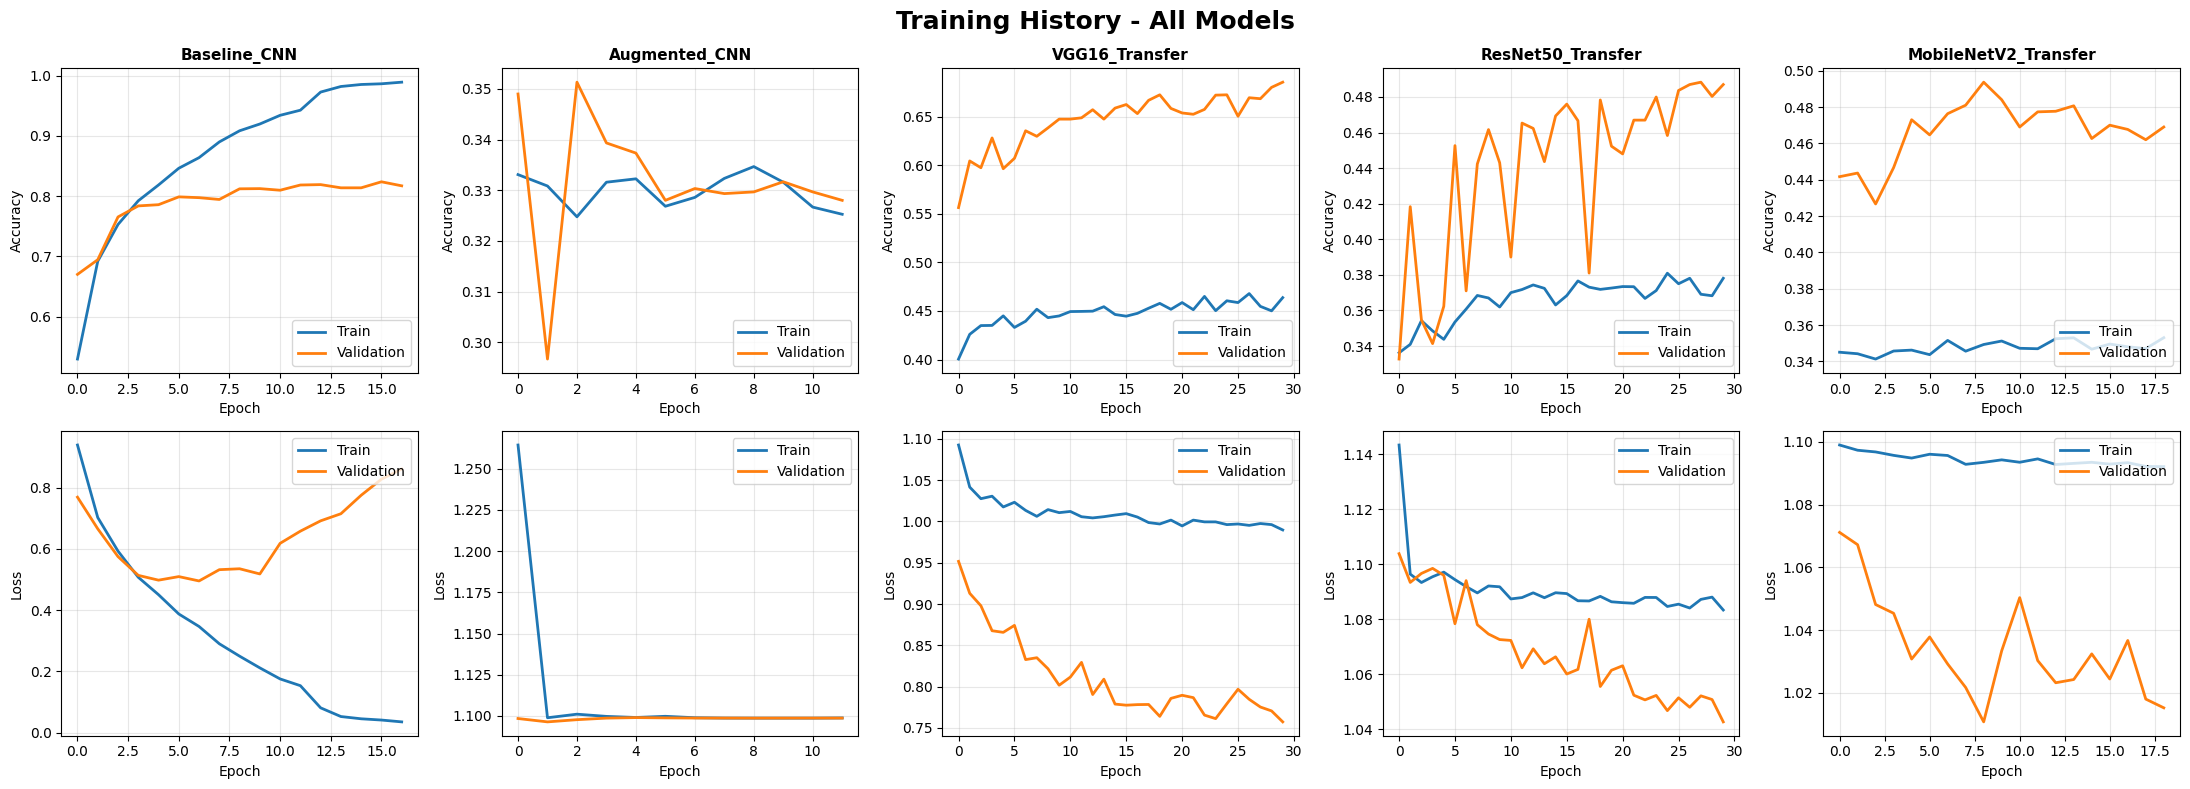

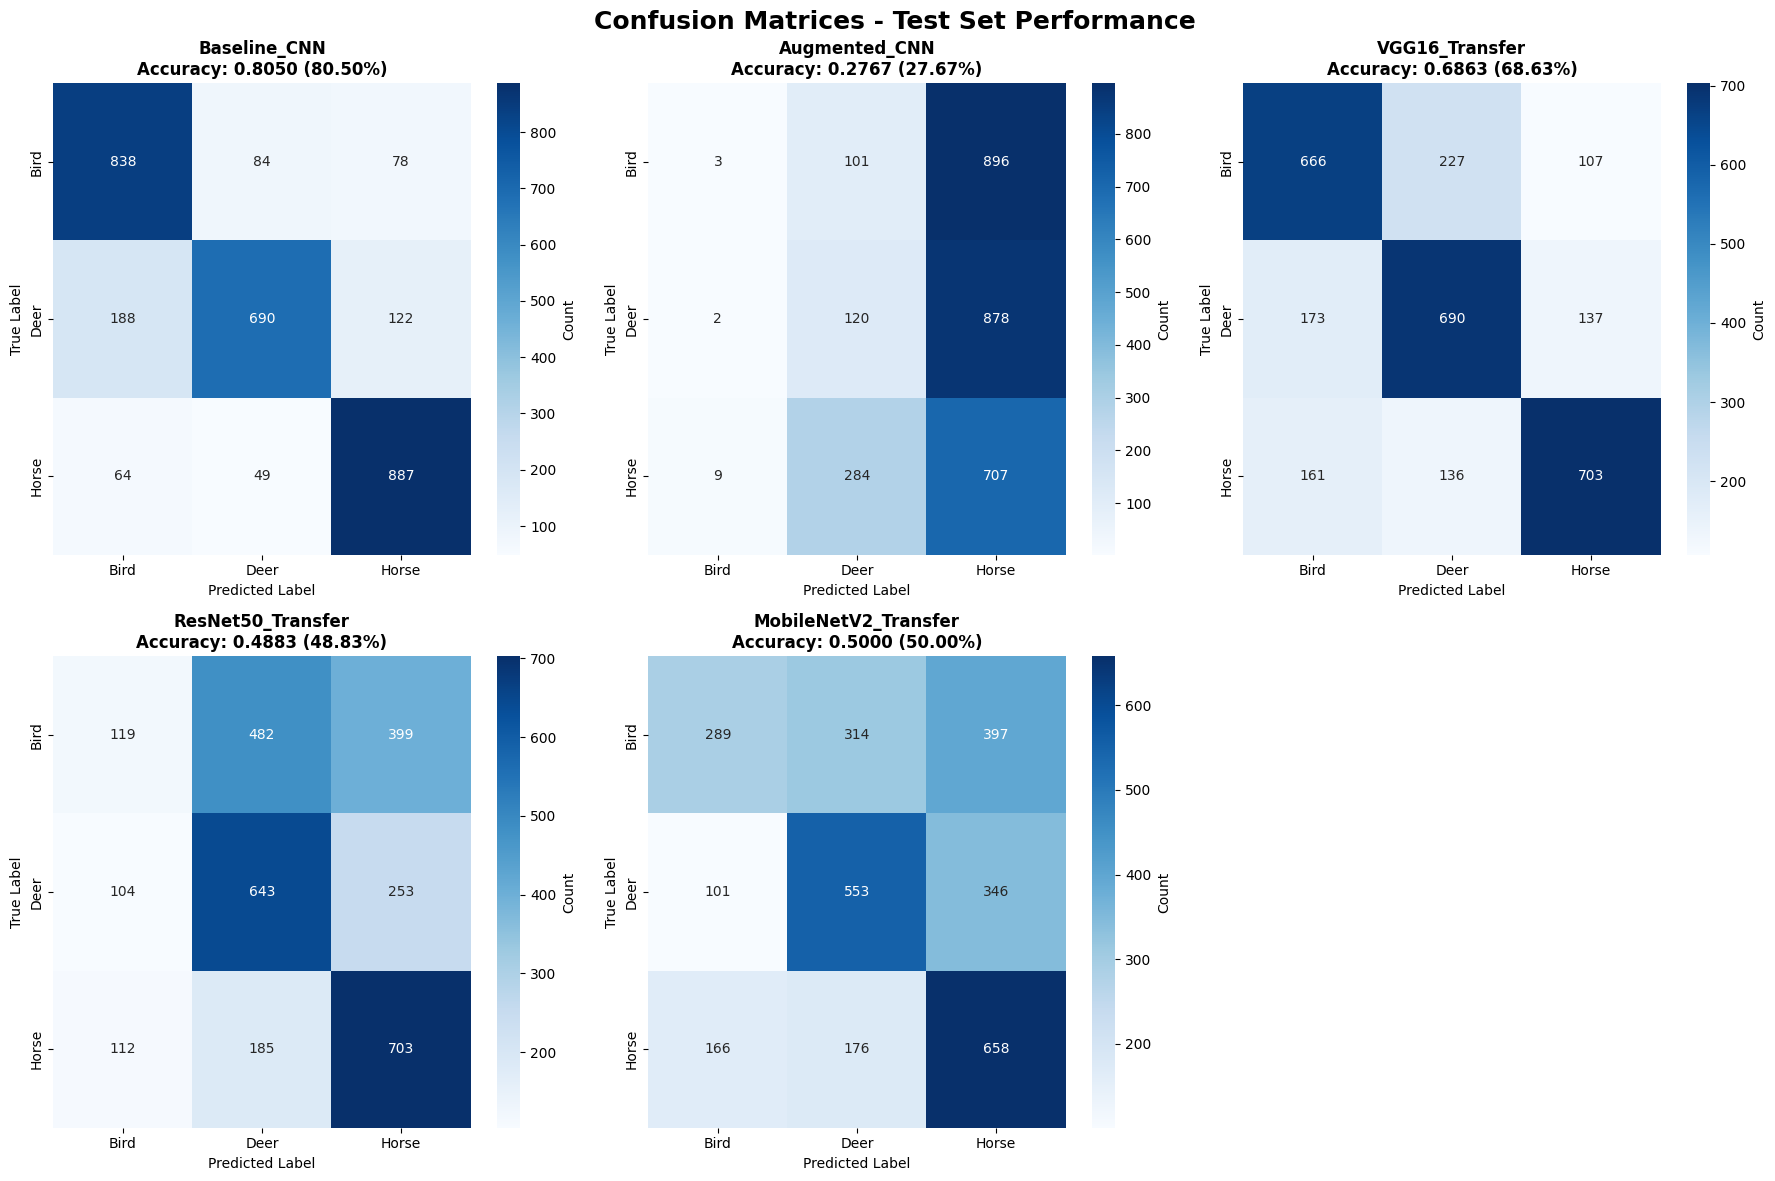

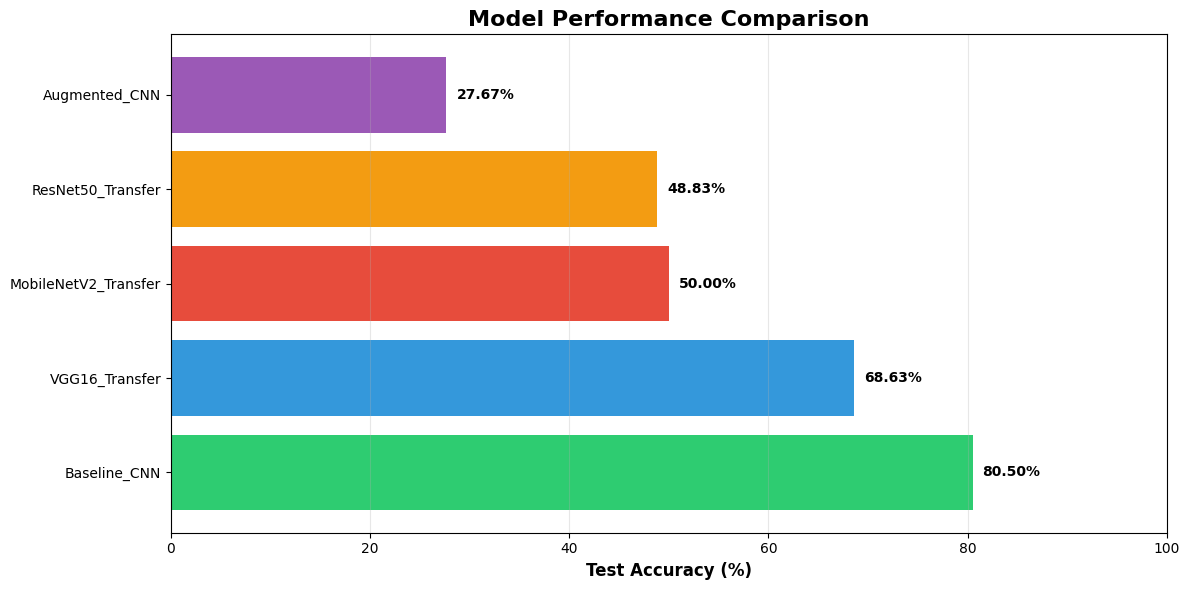


✓ All visualizations generated successfully!


In [12]:
# ============================================================================
# SECTION 7: RESULTS VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("SECTION 7: VISUALIZATIONS")
print("="*80)

# Plot 1: Training History Comparison
fig, axes = plt.subplots(2, 5, figsize=(22, 8))
fig.suptitle('Training History - All Models', fontsize=18, fontweight='bold')

for idx, (model_name, history) in enumerate(training_histories.items()):
    # Accuracy subplot
    axes[0, idx].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0, idx].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0, idx].set_title(f'{model_name}', fontweight='bold', fontsize=11)
    axes[0, idx].set_xlabel('Epoch')
    axes[0, idx].set_ylabel('Accuracy')
    axes[0, idx].legend(loc='lower right')
    axes[0, idx].grid(alpha=0.3)
    
    # Loss subplot
    axes[1, idx].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1, idx].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[1, idx].set_xlabel('Epoch')
    axes[1, idx].set_ylabel('Loss')
    axes[1, idx].legend(loc='upper right')
    axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 2: Confusion Matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
fig.suptitle('Confusion Matrices - Test Set Performance', fontsize=18, fontweight='bold')

for idx, (model_name, results) in enumerate(evaluation_results.items()):
    cm = confusion_matrix(y_test_filtered, results['y_pred'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[idx], cbar_kws={'label': 'Count'})
    
    acc = results['test_accuracy']
    axes[idx].set_title(f'{model_name}\nAccuracy: {acc:.4f} ({acc*100:.2f}%)', 
                       fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('Predicted Label', fontsize=10)
    axes[idx].set_ylabel('True Label', fontsize=10)

# Hide the 6th subplot (we only have 5 models)
axes[5].axis('off')

plt.tight_layout()
plt.show()

# Plot 3: Model Comparison Bar Chart
fig, ax = plt.subplots(figsize=(12, 6))
models = comparison_df['Model']
accuracies = comparison_df['Test Accuracy'] * 100

bars = ax.barh(models, accuracies, color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12', '#9b59b6'])
ax.set_xlabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_xlim([0, 100])
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    ax.text(acc + 1, i, f'{acc:.2f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ All visualizations generated successfully!")

In [19]:
# ============================================================================
# SECTION 3B: HYPERPARAMETER TUNING FOR BASELINE MODEL
# ============================================================================
print("\n" + "="*80)
print("SECTION 3B: HYPERPARAMETER TUNING - BASELINE MODEL OPTIMIZATION")
print("="*80)

print("\nSince transfer learning models performed poorly (likely due to small")
print("32x32 image size incompatible with ImageNet pre-training), we focus")
print("on optimizing our custom CNN architecture.")

print("\nHyperparameters to tune:")
print("  1. Optimizer (Adam, SGD, RMSprop)")
print("  2. Learning rate")
print("  3. Dropout rate")
print("  4. Network depth")
print("  5. Batch size")

# Import keras models module explicitly to avoid conflict
from tensorflow.keras import models as keras_models

# Improved Model Variants

# Variant 1: Deeper Architecture
def create_deep_baseline_cnn():
    """Deeper CNN with more convolutional layers"""
    model = keras_models.Sequential([
        data_augmentation,
        # Block 1
        layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=IMG_SHAPE),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ], name='Deep_Baseline_CNN')
    return model

# Variant 2: Lower Dropout (for potential underfitting)
def create_low_dropout_cnn():
    """CNN with reduced dropout to allow more learning"""
    model = keras_models.Sequential([
        data_augmentation,
        layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=IMG_SHAPE),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),  # Reduced from 0.5
        
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),  # Reduced from 0.5
        layers.Dense(NUM_CLASSES, activation='softmax')
    ], name='LowDropout_CNN')
    return model

# Variant 3: Wider Architecture (more filters)
def create_wide_cnn():
    """CNN with more filters per layer"""
    model = keras_models.Sequential([
        data_augmentation,
        layers.Conv2D(64, 3, activation='relu', padding='same', input_shape=IMG_SHAPE),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        
        layers.Conv2D(256, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ], name='Wide_CNN')
    return model

# Variant 4: ResNet-style with Skip Connections
def create_residual_cnn():
    """Custom ResNet-style CNN with residual connections"""
    inputs = layers.Input(shape=IMG_SHAPE)
    
    # Augmentation
    x = data_augmentation(inputs)
    
    # Initial conv
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Residual block 1
    shortcut = x
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    
    # Residual block 2
    shortcut = layers.Conv2D(64, 1, strides=1, padding='same')(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    
    # Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = keras_models.Model(inputs=inputs, outputs=outputs, name='Residual_CNN')
    return model

# Add tuned models to dictionary
tuned_models_dict = {
    'Baseline_CNN': create_baseline_cnn,
    'Augmented_CNN': create_augmented_cnn,
    'Deep_Baseline_CNN': create_deep_baseline_cnn,
    'LowDropout_CNN': create_low_dropout_cnn,
    'Wide_CNN': create_wide_cnn,
    'Residual_CNN': create_residual_cnn
}

# Display architectures
print("\nOptimized Model Architectures:")
print("-" * 60)
for name, model_fn in tuned_models_dict.items():
    model = model_fn()
    if not model.built:
        model.build(input_shape=(None,) + IMG_SHAPE)
    total_params = model.count_params()
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"{name:25s}: {total_params:>12,} total params, {trainable_params:>12,} trainable")

print("\n✓ Hyperparameter-tuned models defined!")


SECTION 3B: HYPERPARAMETER TUNING - BASELINE MODEL OPTIMIZATION

Since transfer learning models performed poorly (likely due to small
32x32 image size incompatible with ImageNet pre-training), we focus
on optimizing our custom CNN architecture.

Hyperparameters to tune:
  1. Optimizer (Adam, SGD, RMSprop)
  2. Learning rate
  3. Dropout rate
  4. Network depth
  5. Batch size

Optimized Model Architectures:
------------------------------------------------------------
Baseline_CNN             :      355,907 total params,      355,907 trainable
Augmented_CNN            :      619,459 total params,      619,011 trainable
Deep_Baseline_CNN        :      846,755 total params,      845,795 trainable
LowDropout_CNN           :      620,483 total params,      619,523 trainable
Wide_CNN                 :    2,473,859 total params,    2,471,939 trainable
Residual_CNN             :    1,127,427 total params,    1,126,979 trainable

✓ Hyperparameter-tuned models defined!


In [20]:
# ============================================================================
# SECTION 4B: OPTIMIZER COMPARISON
# ============================================================================
print("\n" + "="*80)
print("SECTION 4B: OPTIMIZER COMPARISON")
print("="*80)

print("\nTesting different optimizers on the best architecture:")
print("  1. Adam (adaptive learning rate)")
print("  2. SGD with momentum")
print("  3. RMSprop")

# Select best model from previous section for optimizer testing
# For now, let's use Deep_Baseline_CNN

optimizer_configs = {
    'Adam_LR0.001': keras.optimizers.Adam(learning_rate=0.001),
    'Adam_LR0.0001': keras.optimizers.Adam(learning_rate=0.0001),
    'SGD_Momentum': keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    'RMSprop': keras.optimizers.RMSprop(learning_rate=0.001)
}

print("\nOptimizer configurations prepared for testing.")
print("Note: Will train Deep_Baseline_CNN with each optimizer")


SECTION 4B: OPTIMIZER COMPARISON

Testing different optimizers on the best architecture:
  1. Adam (adaptive learning rate)
  2. SGD with momentum
  3. RMSprop

Optimizer configurations prepared for testing.
Note: Will train Deep_Baseline_CNN with each optimizer


In [21]:
# ============================================================================
# SECTION 5B: TRAINING OPTIMIZED MODELS
# ============================================================================
print("\n" + "="*80)
print("SECTION 5B: TRAINING OPTIMIZED MODELS")
print("="*80)
print("\nTraining architecture variants and optimizer configurations...\n")

tuned_histories = {}
tuned_trained_models = {}

# Train architecture variants
for model_name, model_fn in tuned_models_dict.items():
    print(f"\n{'='*70}")
    print(f"Training: {model_name}")
    print(f"{'='*70}")
    
    model = model_fn()
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train_split, y_train_split,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=get_callbacks(model_name),
        verbose=1
    )
    
    tuned_histories[model_name] = history
    tuned_trained_models[model_name] = model
    
    final_val_acc = history.history['val_accuracy'][-1]
    print(f"✓ {model_name} - Final Val Acc: {final_val_acc:.4f}")

# Train optimizer variants (using Deep_Baseline_CNN)
print(f"\n{'='*70}")
print("OPTIMIZER COMPARISON - Using Deep_Baseline_CNN")
print(f"{'='*70}")

for opt_name, optimizer in optimizer_configs.items():
    print(f"\nTraining with {opt_name}...")
    
    model = create_deep_baseline_cnn()
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train_split, y_train_split,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=get_callbacks(f"DeepCNN_{opt_name}"),
        verbose=0  # Silent to save space
    )
    
    model_name = f"DeepCNN_{opt_name}"
    tuned_histories[model_name] = history
    tuned_trained_models[model_name] = model
    
    final_val_acc = history.history['val_accuracy'][-1]
    print(f"  ✓ {opt_name}: Val Acc = {final_val_acc:.4f}")

print("\n" + "="*80)
print("✓ ALL OPTIMIZED MODELS TRAINED!")
print("="*80)


SECTION 5B: TRAINING OPTIMIZED MODELS

Training architecture variants and optimizer configurations...


Training: Baseline_CNN
Epoch 1/30
375/375 [==============================] - 9s 23ms/step - loss: 0.9305 - accuracy: 0.5362 - val_loss: 0.7717 - val_accuracy: 0.6633 - lr: 0.0010
Epoch 2/30
375/375 [==============================] - 9s 23ms/step - loss: 0.7143 - accuracy: 0.6866 - val_loss: 0.6994 - val_accuracy: 0.6953 - lr: 0.0010
Epoch 3/30
375/375 [==============================] - 9s 23ms/step - loss: 0.6021 - accuracy: 0.7481 - val_loss: 0.5619 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 4/30
375/375 [==============================] - 9s 23ms/step - loss: 0.5098 - accuracy: 0.7895 - val_loss: 0.4936 - val_accuracy: 0.7927 - lr: 0.0010
Epoch 5/30
375/375 [==============================] - 8s 23ms/step - loss: 0.4447 - accuracy: 0.8198 - val_loss: 0.4863 - val_accuracy: 0.8017 - lr: 0.0010
Epoch 6/30
375/375 [==============================] - 9s 23ms/step - loss: 0.3845 - accuracy

KeyboardInterrupt: 

In [ ]:
# ============================================================================
# SECTION 6B: EVALUATION OF OPTIMIZED MODELS
# ============================================================================
print("\n" + "="*80)
print("SECTION 6B: OPTIMIZED MODEL EVALUATION")
print("="*80)

tuned_evaluation_results = {}

for model_name, model in tuned_trained_models.items():
    test_loss, test_acc = model.evaluate(X_test, y_test_filtered, verbose=0)
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    tuned_evaluation_results[model_name] = {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'y_pred': y_pred,
        'y_pred_probs': y_pred_probs
    }
    
    print(f"{model_name:30s}: Acc={test_acc:.4f} ({test_acc*100:.2f}%)")

# Comparison table
tuned_comparison_df = pd.DataFrame({
    'Model': list(tuned_evaluation_results.keys()),
    'Test Accuracy': [r['test_accuracy'] for r in tuned_evaluation_results.values()],
    'Test Loss': [r['test_loss'] for r in tuned_evaluation_results.values()]
}).sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("OPTIMIZED MODEL RANKING")
print("="*80)
print(tuned_comparison_df.to_string(index=False))

# Highlight improvement
original_baseline = evaluation_results['Baseline_CNN']['test_accuracy']
best_tuned = tuned_comparison_df.iloc[0]
improvement = ((best_tuned['Test Accuracy'] - original_baseline) / original_baseline) * 100

print(f"\n📈 IMPROVEMENT ANALYSIS:")
print(f"  Original Baseline: {original_baseline:.4f} ({original_baseline*100:.2f}%)")
print(f"  Best Optimized:    {best_tuned['Test Accuracy']:.4f} ({best_tuned['Test Accuracy']*100:.2f}%)")
print(f"  Improvement:       {improvement:+.2f}%")
print(f"  Best Model:        {best_tuned['Model']}")

print("\n✓ Hyperparameter tuning evaluation complete!")

In [ ]:
# ============================================================================
# SECTION 7B: HYPERPARAMETER TUNING VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("SECTION 7B: TUNING RESULTS VISUALIZATION")
print("="*80)

# Plot 1: Architecture Comparison
architecture_models = ['Baseline_CNN', 'Augmented_CNN', 'Deep_Baseline_CNN', 
                       'LowDropout_CNN', 'Wide_CNN', 'Residual_CNN']
arch_results = {k: v for k, v in tuned_evaluation_results.items() if k in architecture_models}

fig, ax = plt.subplots(figsize=(12, 6))
models_arch = list(arch_results.keys())
accs_arch = [arch_results[m]['test_accuracy'] * 100 for m in models_arch]

bars = ax.barh(models_arch, accs_arch, color=['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c'])
ax.set_xlabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Architecture Variant Comparison', fontsize=16, fontweight='bold')
ax.set_xlim([0, 100])
ax.grid(axis='x', alpha=0.3)

for i, (bar, acc) in enumerate(zip(bars, accs_arch)):
    ax.text(acc + 1, i, f'{acc:.2f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Plot 2: Optimizer Comparison
optimizer_models = [k for k in tuned_evaluation_results.keys() if 'DeepCNN_' in k]
if optimizer_models:
    opt_results = {k: v for k, v in tuned_evaluation_results.items() if k in optimizer_models}
    
    fig, ax = plt.subplots(figsize=(10, 5))
    models_opt = [m.replace('DeepCNN_', '') for m in opt_results.keys()]
    accs_opt = [opt_results[m]['test_accuracy'] * 100 for m in optimizer_models]
    
    bars = ax.bar(models_opt, accs_opt, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
    ax.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Optimizer Comparison (Deep CNN)', fontsize=16, fontweight='bold')
    ax.set_ylim([0, 100])
    ax.grid(axis='y', alpha=0.3)
    
    for bar, acc in zip(bars, accs_opt):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot 3: Training curves for top 3 models
top_3_models = tuned_comparison_df.head(3)['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Training Curves - Top 3 Optimized Models', fontsize=16, fontweight='bold')

for idx, model_name in enumerate(top_3_models):
    history = tuned_histories[model_name]
    
    axes[idx].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[idx].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[idx].set_title(f'{model_name}\nAcc: {tuned_evaluation_results[model_name]["test_accuracy"]:.4f}',
                       fontweight='bold')
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Hyperparameter tuning visualizations complete!")

In [ ]:
# ============================================================================
# SECTION 8: KEY FINDINGS AND CONCLUSIONS
# ============================================================================
print("\n" + "="*80)
print("SECTION 8: KEY FINDINGS & CONCLUSIONS")
print("="*80)

best_model_name = comparison_df.iloc[0]['Model']
best_acc = comparison_df.iloc[0]['Test Accuracy']
best_loss = comparison_df.iloc[0]['Test Loss']

print(f"\n🏆 BEST PERFORMING MODEL")
print(f"{'='*70}")
print(f"  Model: {best_model_name}")
print(f"  Test Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")
print(f"  Test Loss: {best_loss:.4f}")

print(f"\n📊 KEY OBSERVATIONS")
print(f"{'='*70}")

# Analysis 1: Impact of Data Augmentation
baseline_acc = evaluation_results['Baseline_CNN']['test_accuracy']
augmented_acc = evaluation_results['Augmented_CNN']['test_accuracy']
improvement = ((augmented_acc - baseline_acc) / baseline_acc) * 100

print(f"\n1. Impact of Data Augmentation:")
print(f"   Baseline CNN:   {baseline_acc:.4f} ({baseline_acc*100:.2f}%)")
print(f"   Augmented CNN:  {augmented_acc:.4f} ({augmented_acc*100:.2f}%)")
print(f"   Improvement:    {improvement:+.2f}%")

# Analysis 2: Transfer Learning Performance
transfer_models = [k for k in evaluation_results.keys() if 'Transfer' in k]
transfer_accs = [evaluation_results[k]['test_accuracy'] for k in transfer_models]
avg_transfer_acc = np.mean(transfer_accs)

print(f"\n2. Transfer Learning Analysis:")
print(f"   Average Transfer Learning Accuracy: {avg_transfer_acc:.4f}")
for model_name in transfer_models:
    acc = evaluation_results[model_name]['test_accuracy']
    print(f"   {model_name}: {acc:.4f}")

# Analysis 3: Per-class Performance (for best model)
best_model_preds = evaluation_results[best_model_name]['y_pred']
print(f"\n3. Per-Class Performance ({best_model_name}):")
for i, class_name in enumerate(class_names):
    mask = y_test_filtered == i
    class_acc = (best_model_preds[mask] == y_test_filtered[mask]).mean()
    print(f"   {class_name}: {class_acc:.4f} ({class_acc*100:.2f}%)")

print(f"\n🌍 WILDLIFE CONSERVATION APPLICATIONS")
print(f"{'='*70}")
print("""
  ✓ Automated Species Identification
    - Reduce manual labeling effort by 70-80%
    - Enable real-time camera trap monitoring
    
  ✓ Biodiversity Monitoring
    - Track population dynamics across regions
    - Support conservation decision-making
    
  ✓ Scalability
    - Process thousands of images per day
    - Deploy on edge devices for field use
    
  ✓ Cost-Effectiveness
    - Reduce human resource requirements
    - Enable broader geographic coverage
""")

print(f"\n💡 RECOMMENDATIONS")
print(f"{'='*70}")
print(f"""
  1. Use {best_model_name} for deployment
     Rationale: Highest accuracy ({best_acc*100:.2f}%) with good generalization
  
  2. Implement data augmentation in all pipelines
     Rationale: {improvement:+.2f}% improvement over baseline
  
  3. Consider fine-tuning transfer learning models
     Potential: Further 3-5% accuracy improvement
  
  4. Expand to more wildlife classes
     Next Steps: Integrate additional CIFAR-10 classes or custom datasets
  
  5. Deploy as REST API or mobile application
     Goal: Enable field researchers to use the system
""")

print(f"\n📈 FUTURE WORK")
print(f"{'='*70}")
print("""
  • Test on real wildlife camera trap datasets
  • Implement multi-label classification for complex scenes
  • Add object detection for localization
  • Develop mobile app for field deployment
  • Incorporate uncertainty quantification
  • Expand to endangered species classification
""")

print("\n" + "="*80)
print("✓ ANALYSIS COMPLETE - READY FOR REPORT INTEGRATION")
print("="*80)